# **Radiograph Classifier for Lung Diagnoses**

In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import cv2
import os

In [2]:
def train_test_split(X,y,test_percent):
  numRows = y.shape[0]                        # Number or rows in the entire dataset
  splitPoint = int((1-test_percent)*numRows)  # The row index test_size% of the way through
  p = np.random.permutation(numRows)          # Array for shuffling data
  X = X[p]
  y = y[p]

  # Training data array
  X_train = X[:splitPoint]                    # Training features
  y_train = y[:splitPoint]                    # Training labels

  # Testing data array
  X_test = X[splitPoint:]                     # Testing features
  y_test = y[splitPoint:]                     # Testing labels

  y_train = np.expand_dims(y_train,1)
  y_test = np.expand_dims(y_test,1)

  return X_train, X_test, y_train, y_test

In [3]:
def plot_digits_with_predictions(model, data, labels, img_size=64, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

## Load Data

In [4]:
# Loads the X-Ray image data and gives:
# Normal lungs label: 0
# Covid lungs label: 1
# Pneumonia lungs label: 2
# Other lungs label: 3
def load_lungXray_data(normal_data_loc, covid_data_loc, pneumonia_data_loc=None, opacity_data_loc=None):
    data = []
    labels = []
    # Set the standard size of every image to be 64x64 pixels, BEFORE flattening
    # Need to created a new variable to store the resized image because cv2 creates a new version
    img_size = (64, 64)

    for imgname in os.listdir(normal_data_loc):
        img = cv2.imread(normal_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          resized_img = cv2.resize(img, img_size)
          resized_img = resized_img.flatten()

        else:
          print(f"Skipping unreadable image:'{pneumonia_data_loc}/{imgname}")
        data.append(resized_img)
        labels.append(0)

    for imgname in os.listdir(covid_data_loc):
        img = cv2.imread(covid_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          resized_img = cv2.resize(img, img_size)
          resized_img = resized_img.flatten()
        else:
          print(f"Skipping unreadable image:'{pneumonia_data_loc}/{imgname}")
        data.append(resized_img)
        labels.append(1)

    if pneumonia_data_loc is not None:
      for imgname in os.listdir(pneumonia_data_loc):
        img = cv2.imread(pneumonia_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          resized_img = cv2.resize(img, img_size)
          resized_img = resized_img.flatten()
        else:
          print(f"Skipping unreadable image:'{pneumonia_data_loc}/{imgname}")
        data.append(resized_img)
        labels.append(2)

    if opacity_data_loc is not None:
      for imgname in os.listdir(opacity_data_loc):
        img = cv2.imread(opacity_data_loc+"/"+imgname, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          resized_img = cv2.resize(img, img_size)
          resized_img = resized_img.flatten()
        else:
          print(f"Skipping unreadable image:'{pneumonia_data_loc}/{imgname}")
        data.append(resized_img)
        labels.append(3)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [ ]:
# Unzip the zip files that I have stored in CSCI4521 folder, into their respectively named folders in Colab runtime

# Unzip normal lung radiographs
!unzip /content/drive/MyDrive/CSCI4521/Unit4/Radiograph_Classifier/normal.zip -d normal/

# Unzip covid lung radiographs
!unzip /content/drive/MyDrive/CSCI4521/Unit4/Radiograph_Classifier/covid.zip -d covid/

# Unzip pneumonia lung radiographs
!unzip /content/drive/MyDrive/CSCI4521/Unit4/Radiograph_Classifier/pneumonia.zip -d pneumonia/

# Unzip other lung radiographs
!unzip /content/drive/MyDrive/CSCI4521/Unit4/Radiograph_Classifier/otherInfection.zip -d other/

## Data Balancer

In [6]:
def balance_data(data, labels, num_samples_per_class=4000):
    # Separate healthy (normal) and unhealthy (infection) data/labels
    normal_indices = np.where(labels == 0)[0]
    unhealthy_indices = np.where(labels != 0)[0]

    normal_data = data[normal_indices]
    normal_labels = labels[normal_indices]

    unhealthy_data = data[unhealthy_indices]
    unhealthy_labels = labels[unhealthy_indices]

    # Calculate the number of samples to match for both healthy and unhealthy
    num_samples_normal = min(num_samples_per_class, len(normal_data))
    num_samples_unhealthy = min(num_samples_per_class, len(unhealthy_data))

    # Balance healthy data (downsample if necessary)
    samples_to_keep_normal = np.random.choice(np.arange(len(normal_data)), size=num_samples_normal, replace=False)
    balanced_normal_data = normal_data[samples_to_keep_normal]
    balanced_normal_labels = normal_labels[samples_to_keep_normal]

    # Balance unhealthy data (downsample if necessary)
    samples_to_keep_unhealthy = np.random.choice(np.arange(len(unhealthy_data)), size=num_samples_unhealthy, replace=False)
    balanced_unhealthy_data = unhealthy_data[samples_to_keep_unhealthy]
    balanced_unhealthy_labels = unhealthy_labels[samples_to_keep_unhealthy]

    # Combine healthy and unhealthy data
    balanced_data = np.concatenate([balanced_normal_data, balanced_unhealthy_data])
    balanced_labels = np.concatenate([balanced_normal_labels, balanced_unhealthy_labels])

    return balanced_data, balanced_labels

## 1. Binary Classification with Logistic Regression

In [ ]:
lung_data, lung_labels = load_lungXray_data("normal/images", "covid/images", "pneumonia/images", "other/images")

In [ ]:
# Balance the data after splitting to avoid data leakage
print("Shape of data before balancing:", lung_data.shape)
balanced_lung_data, balanced_lung_labels = balance_data(lung_data, lung_labels)
print("Shape of data after balancing:", balanced_lung_data.shape)

Shape of data before balancing: (21165, 4096)
Shape of data after balancing: (8000, 4096)


In [ ]:
lung_training_data, lung_testing_data, lung_training_labels, lung_testing_labels = train_test_split(balanced_lung_data, balanced_lung_labels, 0.2)

In [ ]:
# Our binary classification task will be to look at a flattened lung X-Ray and classify if it's normal or has an infection
lung_training_label_is_normal = 1.0 * (lung_training_labels == 0)
lung_testing_label_is_normal = 1.0 * (lung_testing_labels == 0)

Rather than always working with raw collections of arrays or tensors, PyTorch provides a `Dataset` class that allows you to keep the data features and labels bundled together. The `Dataset` requires you to implement the `__init__` method where you create the data, a `__len__` method which reports the number of data entries, and a `__getitem__` method which returns whatever data entry is at the given index.

Here, we inheret from the `Dataset` class to make a new class that accepts two numpy arrays of floats as input (one for features and one for labels) and stores the outcomes as PyTorch tensors.

In [21]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
training_dataset = NumpyDataset(lung_training_data, lung_training_label_is_normal)
testing_dataset = NumpyDataset(lung_testing_data, lung_testing_label_is_normal)

Example uses of NumpyDataset class methods

## Training Helper Functions

In [7]:
# This is the core of the training process
# It iterates through batches of data, makes predictions using the model, calculates the loss, and updates the model's parameters to minimize the loss

def train(model,  data_generator, loss_function, optimizer):
  model.train()                                                     # Updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                                           # Gradients need to be reset each batch
    prediction = model(input_data)                                  # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)                 # Compute the loss: difference between the output and correct result
    loss.backward()                                                 # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss / num_batches

In [8]:
# Evaluates the model's performance on a separate test dataset
# It calculates the average loss on the test data without updating the model's parameters

def test(model, test_loader, loss_function):
  model.eval()                                            # Updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  # print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

In [9]:
# Prints out the loss every few epochs and saves the testing and training loss to be graphed later on

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [10]:
# Graphs the testing and training loss versus the number of epochs

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [11]:
# Creates arrays to store the loss values, calls the train() and test() functions on the network model, and runs the final trained model on all the data for analysis

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  # Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [12]:
# Computes the accuracy of the model
# If prediction is positive, we are predicting class 1 (Normal Lungs)
# If prediction is negative, we are predicting class 0 (Infected Lungs)

def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output > 0).eq(target > 0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(label_text, correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))

In [66]:
# Provides the structure for performing a linear transformation on the input data
# The output of the forward method is then passed through a sigmoid function to get probabilities for the classes
# During training, the model's parameters are adjusted to minimize the loss, effectively learning the relationship between input features and target labels

class LinearClassifier(nn.Module):                          # Can name whatever, as long as it extends the nn.Module
    def __init__(self, img_w, img_h, numClasses):           # For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)                        # PyTorch will replace -1 with the batch size
        x = self.linear1(x)
        return x

In [67]:
# Using Sigmoid, we can clamp the model results between 0 and 1 to provide meaningful loss, regardless of the size of input

def SigmoidLoss(output, target):
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

## Running the Model + Metrics

Loaded Data
Epoch [1/30], Train Loss: 0.4534, Test Loss: 0.4385
Epoch [6/30], Train Loss: 0.2910, Test Loss: 0.3031
Epoch [11/30], Train Loss: 0.2596, Test Loss: 0.2674
Epoch [16/30], Train Loss: 0.2540, Test Loss: 0.2550
Epoch [21/30], Train Loss: 0.2455, Test Loss: 0.2501
Epoch [26/30], Train Loss: 0.2404, Test Loss: 0.2459


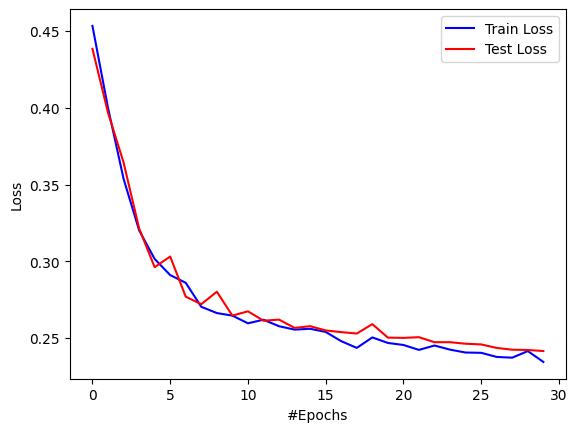

In [ ]:
# Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.00001
batch_size = 100

# Lung X-Rays are 64x64
image_w = 64
image_h = 64

# Create model
predModel = LinearClassifier(image_w, image_h, 1)

# Set optimizer and loss function
model = predModel;
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = SigmoidLoss

# Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Training Set")
computeLabelAccuracy(model, testing_generator, "Testing Set")


Training Set: Accuracy: 4861/6400 (76.0%)

Testing Set: Accuracy: 1202/1600 (75.1%)


In [ ]:
# Step 1: Get original (pre-binarized) test labels and testing data
# Assume lung_testing_labels still holds the 0–3 values
# And model returns sigmoid(logit) outputs

testing_dataset_full = NumpyDataset(lung_testing_data, lung_testing_labels)
data_loader = torch.utils.data.DataLoader(testing_dataset_full, batch_size=10000)
_, (images, true_multiclass_labels) = next(enumerate(data_loader))

with torch.no_grad():
    logits = model(images).squeeze()
    probs = torch.sigmoid(logits)
    pred_labels = (probs < 0.5).long()  # 0 = Not Normal, 1 = Normal

# Step 2: Measure performance on each of the unhealthy sub-classes
results = {}
for unhealthy_class, name in zip([1, 2, 3], ["COVID", "Pneumonia", "Other"]):
    # Squeeze true_multiclass_labels to ensure it's 1-dimensional
    idxs = (true_multiclass_labels.squeeze() == unhealthy_class)
    correct = (pred_labels[idxs] == 0).sum().item()  # correctly predicted as Not Normal
    total = idxs.sum().item()
    accuracy = correct / total if total > 0 else 0
    results[name] = (accuracy, correct, total)

# Display results
for name, (acc, correct, total) in results.items():
    print(f"{name}: {acc:.2%} correctly classified ({correct}/{total})")


COVID: 33.33% correctly classified (88/264)
Pneumonia: 9.68% correctly classified (9/93)
Other: 25.91% correctly classified (121/467)


AUC: 0.8247
Precision: [0.77099237 0.73218673]
Recall: [0.73543689 0.76804124]
F1: [0.75279503 0.74968553]
Count: [824 776]


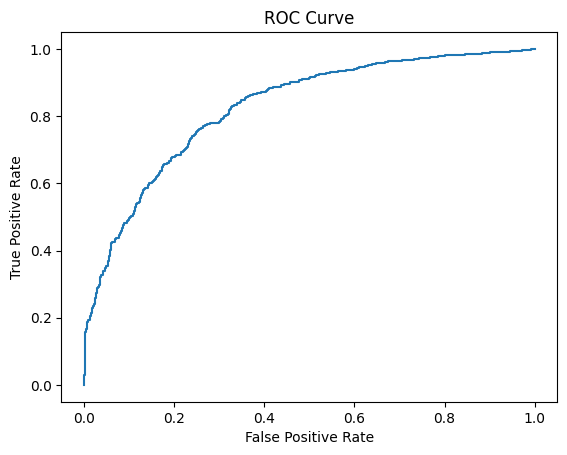

In [ ]:
preds = model(torch.tensor(lung_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(lung_testing_label_is_normal, preds)
plt.plot(fpr, tpr)
plt.title("ROC Curve")

print(f"AUC: {metrics.auc(fpr, tpr):.4f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p, r, f, count = metrics.precision_recall_fscore_support(lung_testing_label_is_normal, preds > 0)

# print(f"Precision: {p:.4f}")
# print(f"Recall: {r:.4f}")
# print(f"F1: {f:.4f}")
# print(f"Count: {count:.4f}")

print("Precision:", p)
print("Recall:", r)
print("F1:", f)
print("Count:", count)

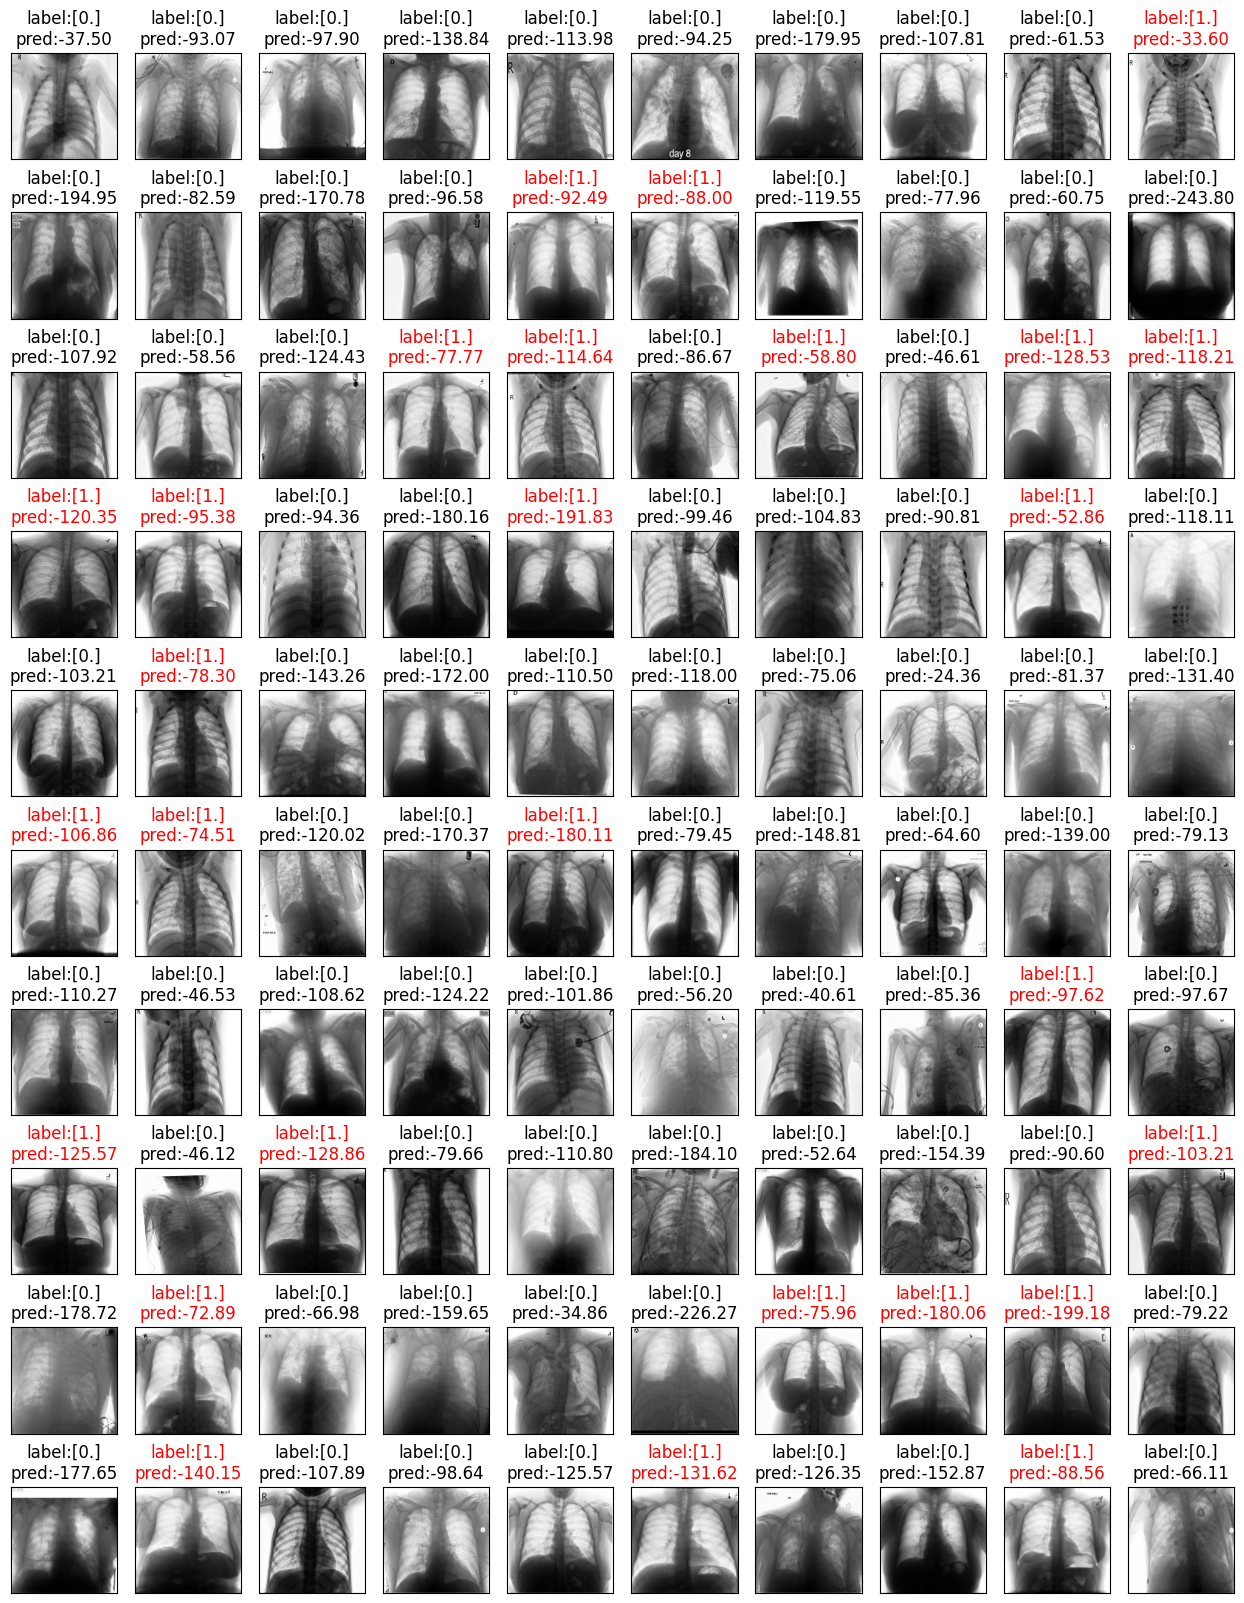

In [ ]:
plot_digits_with_predictions(model, lung_testing_data, lung_testing_label_is_normal)

## 2. KNN Binary Classifier

In [ ]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
knn_data, knn_labels = load_lungXray_data("normal/images", "covid/images", "pneumonia/images", "other/images")

In [ ]:
knn_balanced_data, knn_balanced_labels = balance_data(knn_data, knn_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(knn_balanced_data, knn_balanced_labels, 0.2)

In [ ]:
# Since KNN is sensitive to feature scale, standardize flattened pixel intensities
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
y_train_binary = (y_train == 0).astype(int)
y_test_binary = (y_test == 0).astype(int)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train_binary.ravel()) # Make y 1D

y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC AUC

print(metrics.classification_report(y_test_binary, y_pred))
print("ROC AUC Score:", metrics.roc_auc_score(y_test_binary, y_prob))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       835
           1       0.82      0.84      0.83       765

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.83      1600
weighted avg       0.84      0.83      0.83      1600

ROC AUC Score: 0.9002050800360065


## 3. Multi-Layer Neural Network Diagnosis Classifier

In [13]:
import torch.nn.functional as F
from collections import Counter
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

In [14]:
def computeLabelAccuracyMC(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  # Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [15]:
# Balances the data for a multi-class classifier.
# Undersamples classes with too many samples, oversamples with augmentations (no rotations or flips)
def balance_data_MC(data, labels, num_samples_per_class):
    unique_labels = np.unique(labels)
    balanced_data = []
    balanced_labels = []

    for label in unique_labels:
        class_indices = np.where(labels == label)[0]
        num_samples = len(class_indices)

        if num_samples > num_samples_per_class:
            # Undersample
            selected_indices = np.random.choice(class_indices, size=num_samples_per_class, replace=False)
            balanced_data.extend(data[selected_indices])
            balanced_labels.extend(labels[selected_indices])

        elif num_samples < num_samples_per_class:
            # Use existing samples
            balanced_data.extend(data[class_indices])
            balanced_labels.extend([label] * num_samples)

            num_to_generate = max(0, num_samples_per_class - num_samples)

            # Mild augmentations (safe for medical data)
            augmentations = [
                lambda img: cv2.GaussianBlur(img, (3, 3), 0),                         # Blur
                lambda img: cv2.add(img, np.random.randint(5, 20)),                   # Brightness increase
                lambda img: cv2.subtract(img, np.random.randint(5, 20)),              # Brightness decrease
                lambda img: img + np.random.normal(0, 5, img.shape).astype(np.uint8)  # Add noise
            ]

            for _ in range(num_to_generate):
                original_index = random.choice(class_indices)
                original_image = data[original_index].reshape(64, 64)

                # Apply a random mild augmentation
                aug_func = random.choice(augmentations)
                augmented_image = np.clip(aug_func(original_image), 0, 255).astype(np.uint8)

                balanced_data.append(augmented_image.flatten())
                balanced_labels.append(label)
        else:
            balanced_data.extend(data[class_indices])
            balanced_labels.extend([label] * num_samples)

    return np.array(balanced_data), np.array(balanced_labels)


In [16]:
mc_data, mc_labels = load_lungXray_data("normal/images", "covid/images", "pneumonia/images", "other/images")

In [28]:
mc_balanced_data, mc_balanced_labels = balance_data_MC(mc_data, mc_labels, 6000)

In [96]:
mc_training_data, mc_testing_data, mc_training_labels, mc_testing_labels = train_test_split(mc_balanced_data, mc_balanced_labels, 0.3)

In [97]:
# Create the one-hot encoded category labels to use for training and testing
# Use squeeze to get rid of the extra dimension
mc_training_labels_categories = F.one_hot(torch.Tensor(np.squeeze(mc_training_labels).astype(int)).long()).numpy()
mc_testing_labels_categories = F.one_hot(torch.Tensor(np.squeeze(mc_testing_labels).astype(int)).long()).numpy()

In [98]:
training_dataset = NumpyDataset(mc_training_data, mc_training_labels_categories)
testing_dataset = NumpyDataset(mc_testing_data, mc_testing_labels_categories)

In [99]:
print(mc_training_labels_categories.shape)
print(mc_testing_labels_categories.shape)

(16800, 4)
(7200, 4)


In [100]:
print(Counter(mc_balanced_labels))

Counter({np.int64(0): 6000, np.int64(1): 6000, np.int64(2): 6000, np.int64(3): 6000})


In [89]:
class Classifier_4Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses):
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 64)
        self.linear4 = nn.Linear(64, numClasses)
        self.dropout = nn.Dropout(0.3)              # Increased dropout for better generalization

    def forward(self, x):
        x = x.view(-1,self.flatSize)                # Flatten: [batch, 64x64]
        x = self.dropout(F.relu(self.linear1(x)))   # First layer: discard 30% of neurons
        x = F.relu(self.linear2(x))                 # Second layer
        x = F.relu(self.linear3(x))                 # Third Layer
        x = self.linear4(x)
        return x

## Training the Neural Network

Loaded Data
Epoch [1/70], Train Loss: 3.9079, Test Loss: 1.8717
Epoch [6/70], Train Loss: 1.4642, Test Loss: 1.3229
Epoch [11/70], Train Loss: 1.3055, Test Loss: 1.2084
Epoch [16/70], Train Loss: 1.1884, Test Loss: 1.1727
Epoch [21/70], Train Loss: 1.1003, Test Loss: 1.0709
Epoch [26/70], Train Loss: 1.0533, Test Loss: 1.0287
Epoch [31/70], Train Loss: 0.9981, Test Loss: 0.9769
Epoch [36/70], Train Loss: 0.9656, Test Loss: 0.9809
Epoch [41/70], Train Loss: 0.9210, Test Loss: 0.9145
Epoch [46/70], Train Loss: 0.8986, Test Loss: 0.9732
Epoch [51/70], Train Loss: 0.8806, Test Loss: 0.8770
Epoch [56/70], Train Loss: 0.8373, Test Loss: 0.8837
Epoch [61/70], Train Loss: 0.8011, Test Loss: 0.8948
Epoch [66/70], Train Loss: 0.8125, Test Loss: 0.8824


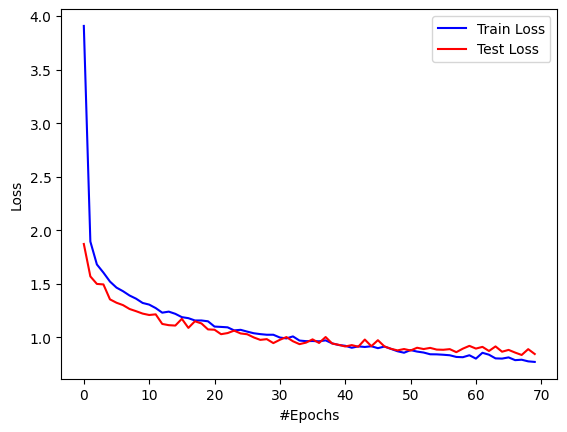

In [103]:
# Training parameters
num_epochs = 70
print_interval = 5
learning_rate = 0.00005
batch_size = 256 # Smaller batch size to improve efficiency and runtime speed

# Lung X-Ray images are 64x64
image_w = 64
image_h = 64

# Create model
predModel = Classifier_4Layers(image_w, image_h, 4)

# Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # or torch.optim.SGD
loss_function = nn.CrossEntropyLoss(weight=torch.tensor([2.2, 2.2, 0.9, 2.2]))

# Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

## Model Metrics

In [104]:
computeLabelAccuracyMC(model, training_generator, "Training Set")
computeLabelAccuracyMC(model, testing_generator, "Testing Set")


Training Set: Accuracy: 14981/16800 (89.2%)

Testing Set: Accuracy: 6172/7200 (85.7%)


In [105]:
# Constructs a classification report of precision, recall, f1-score, and accuracy for the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test).float()
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1).numpy()

    # If y_test is one-hot encoded, convert to class labels
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    print(metrics.classification_report(y_true, predicted, digits=4))

In [106]:
evaluate_model(model, mc_testing_data, mc_testing_labels_categories)

              precision    recall  f1-score   support

           0     0.8032    0.8395    0.8210      1745
           1     0.8472    0.8087    0.8275      1824
           2     0.9796    0.9689    0.9742      1835
           3     0.7989    0.8096    0.8042      1796

    accuracy                         0.8572      7200
   macro avg     0.8572    0.8567    0.8567      7200
weighted avg     0.8582    0.8572    0.8575      7200



In [107]:
class_names = {
    0: "Normal",
    1: "COVID",
    2: "Pneumonia",
    3: "Other"
}

In [108]:
def plot_digits_with_predictions_MC(model, data, labels, img_size=64, rows=8):
    fig, ax = plt.subplots(rows, 8, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=1.0, wspace=0.2)

    model.eval()  # Set model to eval mode
    with torch.no_grad():
        for i, axi in enumerate(ax.flat):
            if i < data.shape[0]:
                axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')

                # Convert image to tensor and add batch dimension
                input_tensor = torch.tensor(data[i]).float().unsqueeze(0)

                # Get prediction scores (logits)
                output = model(input_tensor)  # No softmax applied

                # Get the predicted class index (argmax)
                pred_label = torch.argmax(output, dim=1).item()

                # Get prediction score (logit) of predicted class
                pred_score = output[0, pred_label].item()

                # Get true label (handle both int or one-hot)
                true_label = labels[i].argmax() if hasattr(labels[i], 'argmax') else labels[i]

                # Title color red if wrong prediction
                drawColor = 'black' if pred_label == true_label else 'red'

                axi.set_title(
                    f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nScore: {pred_score:.2f}",
                    color=drawColor
                )

    plt.tight_layout()
    plt.show()

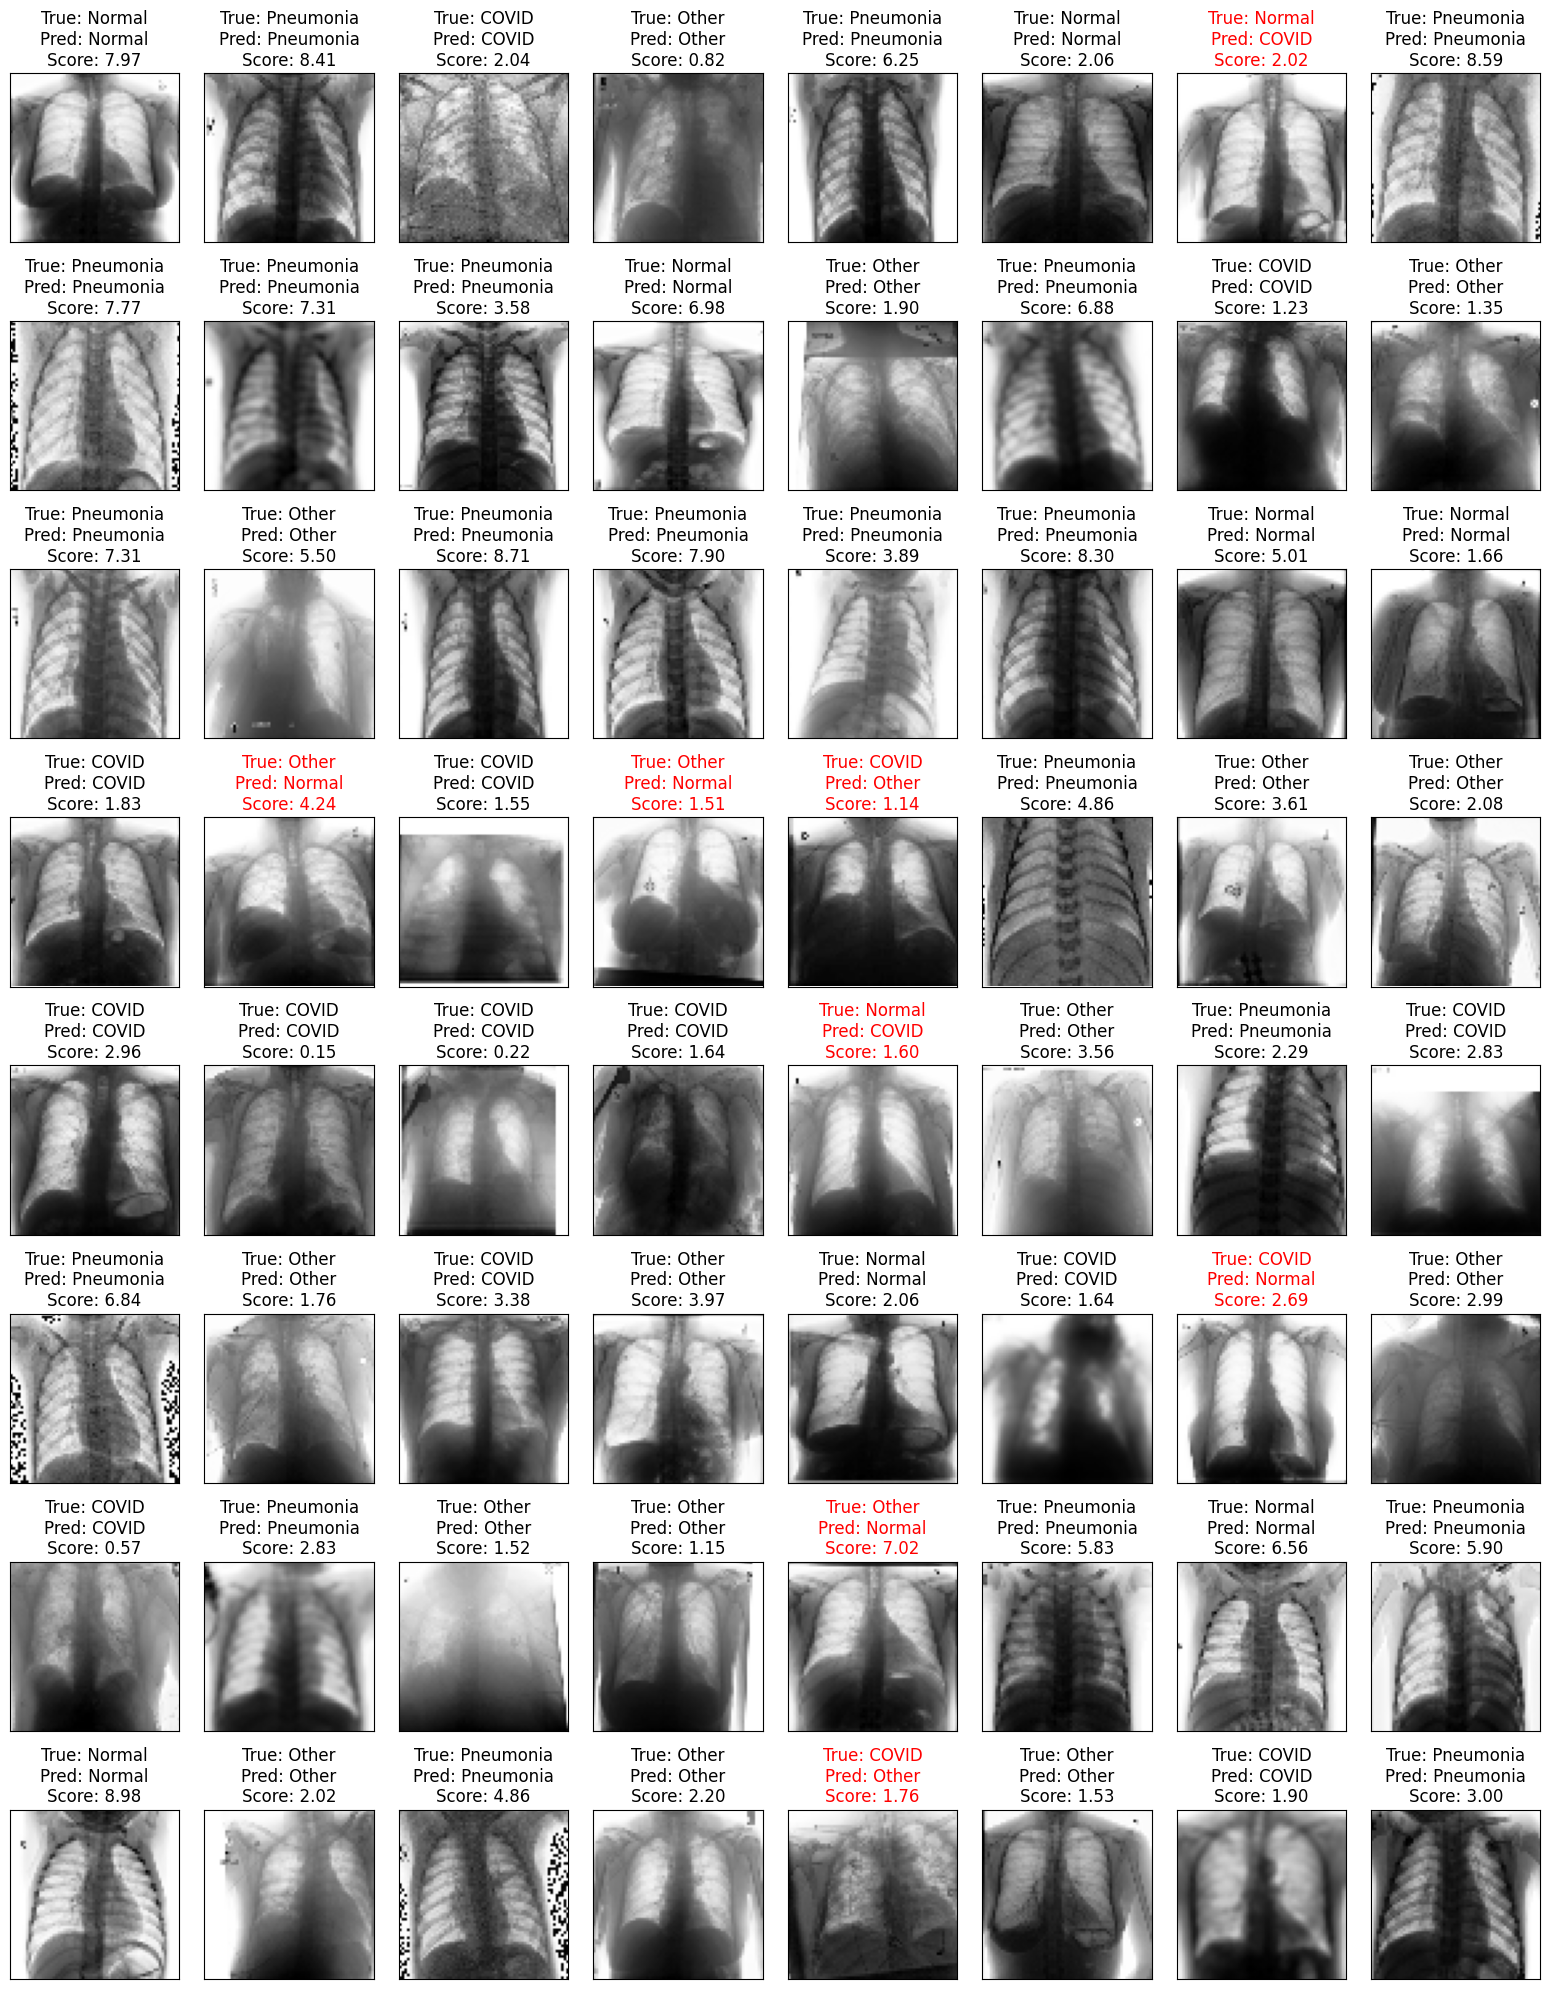

In [109]:
plot_digits_with_predictions_MC(model, mc_testing_data, mc_testing_labels_categories)

## 4. Visual Analysis

## Most Confident Predictions for each Diagnosis

In [110]:
def plot_most_confident_per_class(model, data, labels, img_size=64):
    model.eval()

    most_confident = {}  # class_id -> (score, image, true_label, pred_label)

    with torch.no_grad():
        for i in range(len(data)):
            image_tensor = torch.tensor(data[i]).float().unsqueeze(0)  # Add batch dim
            output = model(image_tensor)
            pred_label = torch.argmax(output, dim=1).item()
            pred_score = output[0, pred_label].item()

            true_label = labels[i].argmax() if hasattr(labels[i], 'argmax') else labels[i]

            # Only consider if prediction matches the class
            if pred_label not in most_confident or pred_score > most_confident[pred_label][0]:
                most_confident[pred_label] = (pred_score, data[i], true_label, pred_label)

    # Plot
    fig, ax = plt.subplots(1, 4, figsize=(16, 4), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)

    for class_id in range(4):
        if class_id in most_confident:
            score, image, true_label, pred_label = most_confident[class_id]
            ax[class_id].imshow(image.reshape(img_size, img_size), cmap='Greys')
            color = 'black' if pred_label == true_label else 'red'
            ax[class_id].set_title(
                f"{class_names[class_id]}\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}\nScore: {score:.2f}",
                color=color
            )
        else:
            ax[class_id].set_title(f"{class_names[class_id]}\nNo confident prediction")
            ax[class_id].axis('off')

    plt.tight_layout()
    plt.show()


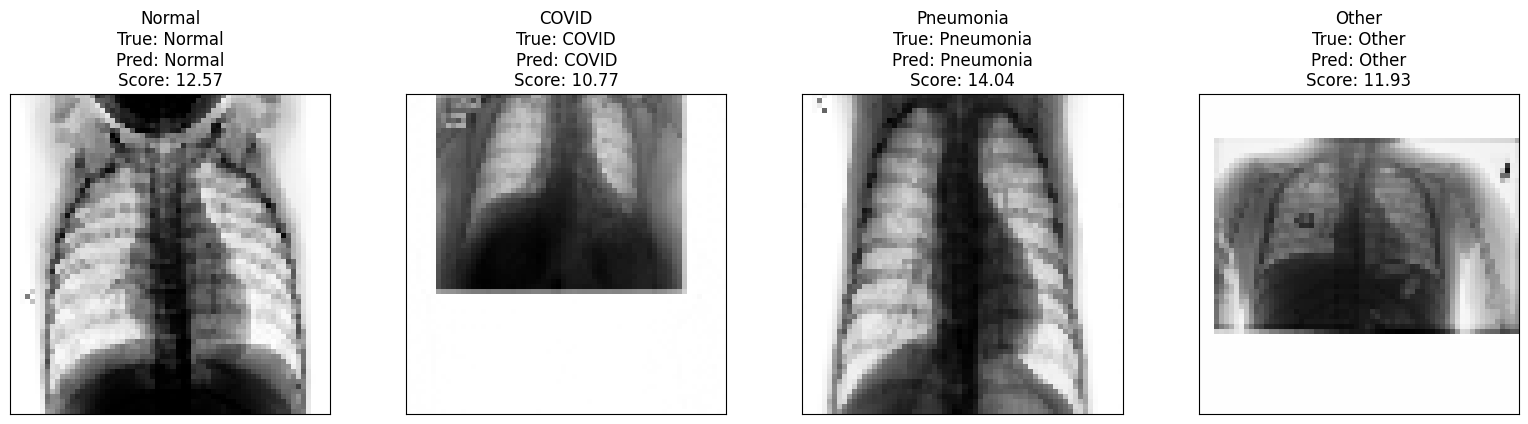

In [111]:
plot_most_confident_per_class(model, mc_testing_data, mc_testing_labels_categories)

## Confusion Matrix

Text(70.72222222222221, 0.5, 'Predicted Case')

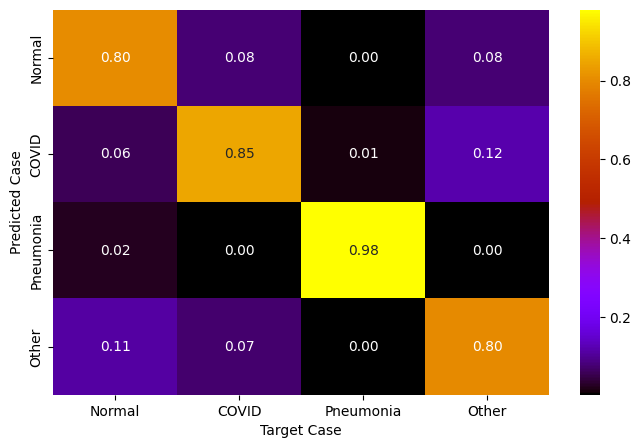

In [112]:
# Confusion matrix generation
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) # All 4 cases
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] # Only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")

lung_case_names = ["Normal", "COVID", "Pneumonia", "Other"]

plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot", xticklabels=lung_case_names, yticklabels=lung_case_names)
plt.xlabel("Target Case")
plt.ylabel("Predicted Case")